In [1]:
from IPython.display import clear_output
# import pipreqsnb  # python reqs

from hyperopt import hp, fmin, tpe, STATUS_OK, STATUS_FAIL, Trials, space_eval
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from catboost import CatBoostRegressor, Pool, metrics
import shap
# from wandb.integration.catboost import WandbCallback
# import wandb
# wandb.login()

import holidays
import geopandas
import pandas as pd  # 1.3.4
from pandasql import sqldf
import numpy as np
from pandarallel import pandarallel
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
from scipy.stats import norm, boxcox_normmax, yeojohnson
from scipy.special import boxcox1p

import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import glob
import pickle
import zipfile

import os
import datetime
import warnings
from pathlib import Path
import logging
import requests
import json
import asyncio
from tqdm import tqdm

from Functions import *
from ETL import *

logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s %(message)s")
warnings.filterwarnings('ignore')
pandarallel.initialize(progress_bar=True)
np.random.seed(42)
sns.set(rc={'figure.figsize': (20, 10)})
sns.set_palette("viridis")
pysqldf = lambda q: sqldf(q, globals())

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


 The main objective is to develop mathematical model(s) that could work in 4 scenarios:
1) Define dynamics (amount) of booked flights by booking class (Saloons (SSC)) (2017-2019 y.)
2) Define seasonality of demand by booking class (2017-2019 y.)
3) Define profiles (segments of clients - b2b/b2c) by booking class (2017-2019 y.)
4) Predict demand (amount of people wanting to buy tickets) by booking class and flight (forecast horizon 2019 validation and 2020 test)

Moreover, there are 5 forecast types (each of them might require a different model):
1) Operative
2) Short-term
3) Mid-term
4) Long-term
5) Very long-term

See details in specification

# Getting and Transforming Data

In [ ]:
# uncomment this if it is the first launch
# transform_provided_data()

In [2]:
# Main datasets provided by Aeroflot
cabin_history = pd.read_pickle("../AeroflotForecast/data/processed/cabin_history")
rasp_history = pd.read_pickle("../AeroflotForecast/data/processed/rasp_history")
class_history = pd.read_pickle("../AeroflotForecast/data/processed/class_history")

In [3]:
class_history = class_history.sample(n=2000000, random_state=42)

## Data Cleaning

In [4]:
# deleting spaces from DataFrame
for categorical_column in cabin_history.select_dtypes('category').columns:
    cabin_history[categorical_column] = cabin_history[categorical_column].str.strip()

# creating date features
cabin_history["TT_DEP_HRS"] = cabin_history["TT_DEP"] / 100  # Local Hour of Departure
# cabin_history["TT_DEP_MIN"] = cabin_history["TT_DEP"] % 100  # Local Minute of Departure
cabin_history["TT_ARR_HRS"] = cabin_history["TT_ARR"] / 100  # Local Hour of Arrival
# cabin_history["TT_ARR_MIN"] = cabin_history["TT_ARR"] % 100  # Local Minute of Arrival

cabin_history['DEP_DATE'] = pd.to_datetime(cabin_history['DEP_DATE'])
cabin_history['DAT_S'] = pd.to_datetime(cabin_history['DAT_S'])

cabin_history['DEP_DATE_MONTH'] = pd.to_datetime(cabin_history['DEP_DATE']).dt.month
cabin_history['DEP_DATE_DAY'] = pd.to_datetime(cabin_history['DEP_DATE']).dt.day
cabin_history['DEP_DATE_WEEK'] = pd.to_datetime(cabin_history['DEP_DATE']).dt.week
cabin_history['DEP_DATE_YEAR'] = pd.to_datetime(cabin_history['DEP_DATE']).dt.year

# cabin_history['route'] = cabin_history[['SEG_ORIG', 'SEG_DEST']].parallel_apply("".join, axis=1)

cabin_history = reduce_memory_usage(cabin_history)

Memory usage of dataframe is 557.20 MB
Memory usage became:  179.28015518188477  MB


In [5]:
# deleting spaces from DataFrame
for categorical_column in class_history.select_dtypes('category').columns:
    class_history[categorical_column] = class_history[categorical_column].str.strip()

# creating date features
# class_history['route'] = class_history[['SORG', 'SDST']].parallel_apply("".join, axis=1)  
class_history['DD'] = pd.to_datetime(class_history['DD'])
class_history['SDAT_S'] = pd.to_datetime(class_history['SDAT_S'])

class_history['DD_month'] = pd.to_datetime(class_history['DD']).dt.month
class_history['DD_dayofyear'] = pd.to_datetime(class_history['DD']).dt.dayofyear
class_history['DD_day'] = pd.to_datetime(class_history['DD']).dt.day
class_history['DD_week'] = pd.to_datetime(class_history['DD']).dt.week
class_history['DD_year'] = pd.to_datetime(class_history['DD']).dt.year

class_history['SDAT_S_month'] = pd.to_datetime(class_history['SDAT_S']).dt.month
class_history['SDAT_S_dayofyear'] = pd.to_datetime(class_history['SDAT_S']).dt.dayofyear
class_history['SDAT_S_day'] = pd.to_datetime(class_history['SDAT_S']).dt.day
class_history['SDAT_S_week'] = pd.to_datetime(class_history['SDAT_S']).dt.week
class_history['SDAT_S_year'] = pd.to_datetime(class_history['SDAT_S']).dt.year

class_history = reduce_memory_usage(class_history)

Memory usage of dataframe is 318.53 MB
Memory usage became:  112.53543853759766  MB


In [6]:
# deleting spaces from DataFrame
for categorical_column in rasp_history.select_dtypes('category').columns:
    rasp_history[categorical_column] = rasp_history[categorical_column].str.strip()

# Downloading External Datasets

External datasets that are being employed:
- Dataset with airports' coordinates and data
- Dataset with weather history
- Dataset with world's cities main description
- Dataset with attractions in Russian cities (further in embeddings can be used to assess their importance). International cities should also be added in the future

Downloading dynamically when forecasting (future development):
- Weather forecast (python_weather)

In [7]:
# airports data
with open('../AeroflotForecast/data/external/airports_data_airportsdata.json') as airports_json:
    airports_data = pd.DataFrame.from_dict(json.load(airports_json), orient='index').reset_index(drop=True)
airports_data.head(2)

icao iata               name     city    subd country  elevation  \
0  19AK  ICY    Icy Bay Airport  Icy Bay  Alaska      US       50.0   
1  2AK6  HGZ  Hog River Airport  Hogatza  Alaska      US      534.0   

         lat         lon                 tz   lid  
0  59.969019 -141.661770  America/Anchorage  19AK  
1  66.176133 -155.684817  America/Anchorage  2AK6

In [8]:
# weather data at the airports
airports_weather_data = pd.read_pickle("../AeroflotForecast/data/external/airports_weather_data.pkl")
airports_weather_data['month'] = airports_weather_data['time'].dt.month
airports_weather_data['year'] = airports_weather_data['time'].dt.year
airports_weather_data['day'] = airports_weather_data['time'].dt.day
airports_weather_data['week'] = airports_weather_data['time'].dt.week
airports_weather_data = airports_weather_data.astype({'time': 'str'})
airports_weather_data.head(2)

iata        time  tavg  tmin  tmax  prcp   snow  wdir  wspd  wpgt  pres  \
0  ADH  2017-01-01 -16.7 -20.4 -13.9   0.4  551.0   NaN   NaN   NaN   NaN   
1  ADH  2017-01-02 -16.5 -19.6 -13.5   0.2  541.0   NaN   NaN   NaN   NaN   

   tsun index station  month  year  day  week  
0   NaN   NaN     NaN      1  2017    1    52  
1   NaN   NaN     NaN      1  2017    2     1

In [9]:
# cities data
cities_data = pd.read_excel("../AeroflotForecast/data/external/world_cities_data.xlsx")
cities_data[cities_data['country'] == 'Russia'].reset_index(drop=True).head(2)

city        city_ascii      lat      lng country iso2 iso3  \
0            Moscow            Moscow  55.7558  37.6178  Russia   RU  RUS   
1  Saint Petersburg  Saint Petersburg  59.9500  30.3167  Russia   RU  RUS   

        admin_name  capital  population          id  
0           Moskva  primary  17332000.0  1643318494  
1  Sankt-Peterburg    admin   5384342.0  1643616350

In [10]:
# tourist attractions in Russia
attractions_data = pd.read_csv("../AeroflotForecast/data/external/russia_tourist_attractions_data.csv")
attractions_data['city'] = (attractions_data['locality'].combine_first(attractions_data['region'])).str.replace(" region", "")
attractions_cities = attractions_data.groupby('city', as_index=False).agg(qnt=('name', 'count'))
attractions_cities.sort_values(by='qnt', ascending=False, ignore_index=True).head(2)

city  qnt
0  St. Petersburg  243
1          Moscow  176

In [11]:
# Russian holidays on the defined period
get_russian_holidays = holidays.country_holidays('RU')

temp_holidays_dates = []
temp_holidays_names = []

for date in pd.date_range(start='2017-01-01', end='2021-01-01'):
    holiday_name = get_russian_holidays.get(date)
    if holiday_name:
        temp_holidays_dates.append(date)
        temp_holidays_names.append(holiday_name)

russian_holidays = pd.DataFrame(list(zip(temp_holidays_dates, temp_holidays_names)), columns=['date', 'holiday'])
russian_holidays.head(3)

date            holiday
0 2017-01-01  New Year Holidays
1 2017-01-02  New Year Holidays
2 2017-01-03  New Year Holidays

# Exploratory Data Analysis

## Cabin DataFrame Exploration

DataFrame Description:
<span style="font-size:14px; font-family:Verdana;"> Data by flights and cabins (saloons) </span>

|No  | Column name                             | Meaning                                                                  |
|:---|:----------------------------------------|:-------------------------------------------------------------------------|
| 1  | <font color="#B2DDF7"> DAT_S </font>    | Date of Recording                                                              |
| 2  | <font color="#B2DDF7"> SAK </font>      | Airlines IATA Code                                                       |
| 3  | <font color="#B2DDF7"> FLT_NUM </font>  | Flight Number                                                            |
| 4  | <font color="#B2DDF7"> DEP_DATE </font> | Departure Date                                                           |
| 5  | <font color="#B2DDF7"> LGNUM </font>    | Leg Number                                                               |
| 6  | <font color="#B2DDF7"> SEG_ORIG </font> | Airport of Origin IATA Code                                           |
| 7  | <font color="#B2DDF7"> SEG_DEST </font> | Airport of Destination IATA Code                                             |
| 8  | <font color="#B2DDF7"> TT_DEP </font>   | Local Time of Departure (format HHMM)                                    |
| 9  | <font color="#B2DDF7"> TT_ARR </font>   | Local Time of Arrival (format HHMM)                                      |
| 10  | <font color="#B2DDF7"> SSC </font>      | Saloons                                                                  |
| 11  | <font color="#B2DDF7"> CAP </font>      | Aircraft Capacity (Configuration)                                        |
| 12  | <font color="#B2DDF7"> UAL </font>      | Level of Authorization by saloon (chairs put on sales incl. overbooking) |
| 13  | <font color="#B2DDF7"> SAL </font>      | Available Chairs by Saloons                                              |
| 14  | <font color="#B2DDF7"> EQUIP  </font>   | Aircraft Type                                                            |
| 15  | <font color="#B2DDF7"> DTD  </font>     | Days till Departure (Booking Window)                                     |

Total number of entries: 4,264,715

In [13]:
print("Number of entries: {:,d}".format(len(cabin_history)))

Number of entries: 4,264,715


Посмотрим на предоставленые данные в резрезе кабин

In [14]:
cabin_history.head()

DAT_S SAK  FLT_NUM   DEP_DATE  LGNUM SEG_ORIG SEG_DEST  TT_DEP  TT_ARR  \
0 2018-03-01  SU     1120 2018-02-01      1      SVO      AER     140     410   
1 2018-02-01  SU     1120 2018-02-01      1      SVO      AER     140     410   
2 2018-01-01  SU     1120 2018-02-01      1      SVO      AER     140     410   
3 2017-12-31  SU     1120 2018-02-01      1      SVO      AER     140     410   
4 2017-12-30  SU     1120 2018-02-01      1      SVO      AER     140     410   

    SSC  ...    UAL   SAL EQUIP DTD  TT_DEP_HRS  TT_ARR_HRS  DEP_DATE_MONTH  \
0  J /Y  ...  12/77   8/9   SU9  -1    1.400391    4.101562               2   
1  J /Y  ...  12/77   8/9   SU9   0    1.400391    4.101562               2   
2  J /Y  ...  12/77   8/4   SU9   1    1.400391    4.101562               2   
3  J /Y  ...  12/77   7/7   SU9   2    1.400391    4.101562               2   
4  J /Y  ...  12/77  6/11   SU9   3    1.400391    4.101562               2   

   DEP_DATE_DAY  DEP_DATE_WEEK  DEP_DATE_YEAR  
0             1              5           2018  
1             1              5           2018  
2             1              5           2018  
3             1              5           2018  
4             1              5           2018  

[5 rows x 21 columns]

In [15]:
show_dataframe_stat(cabin_history)

data_type  nulls_qnt  nulls_share  non_nulls_qnt  \
CAP                   category          0          0.0        4264715   
DAT_S           datetime64[ns]          0          0.0        4264715   
DEP_DATE        datetime64[ns]          0          0.0        4264715   
DEP_DATE_DAY              int8          0          0.0        4264715   
DEP_DATE_MONTH            int8          0          0.0        4264715   
DEP_DATE_WEEK             int8          0          0.0        4264715   
DEP_DATE_YEAR            int16          0          0.0        4264715   
DTD                      int16          0          0.0        4264715   
EQUIP                 category          0          0.0        4264715   
FLT_NUM                  int16          0          0.0        4264715   
LGNUM                     int8          0          0.0        4264715   
SAK                   category          0          0.0        4264715   
SAL                   category          0          0.0        4264715   
SEG_DEST              category          0          0.0        4264715   
SEG_ORIG              category          0          0.0        4264715   
SSC                   category          0          0.0        4264715   
TT_ARR                   int16          0          0.0        4264715   
TT_ARR_HRS             float16          0          0.0        4264715   
TT_DEP                   int16          0          0.0        4264715   
TT_DEP_HRS             float16          0          0.0        4264715   
UAL                   category          0          0.0        4264715   

                cardinality  
CAP                      16  
DAT_S                   917  
DEP_DATE                730  
DEP_DATE_DAY             31  
DEP_DATE_MONTH           12  
DEP_DATE_WEEK            52  
DEP_DATE_YEAR             2  
DTD                     287  
EQUIP                    10  
FLT_NUM                  73  
LGNUM                     1  
SAK                       1  
SAL                    6836  
SEG_DEST                  3  
SEG_ORIG                  3  
SSC                       2  
TT_ARR                  167  
TT_ARR_HRS              167  
TT_DEP                  168  
TT_DEP_HRS              168  
UAL                     530

Как видно из кол-ва уникальных значений, столбцы SAK и LGNUM можно удалить из датасета, т.к. они не несут никакой полезной информации.

In [16]:
# fig = px.box(cabin_history, x="route", y="DTD") # , points="outliers"
# plotly.offline.plot(fig, filename='../AeroflotForecast/visualizations/boxplot_dtd_route')
# fig.show()

In [17]:
cabin_history.describe()

FLT_NUM      LGNUM        TT_DEP        TT_ARR           DTD  \
count  4.264715e+06  4264715.0  4.264715e+06  4.264715e+06  4.264715e+06   
mean   1.352030e+03        1.0  1.320771e+03  1.333084e+03  1.061832e+02   
std    9.330120e+02        0.0  5.953036e+02  6.573955e+02  6.406536e+01   
min    1.116000e+03        1.0  2.000000e+01  5.000000e+00 -1.000000e+00   
25%    1.125000e+03        1.0  9.050000e+02  9.100000e+02  5.100000e+01   
50%    1.133000e+03        1.0  1.335000e+03  1.340000e+03  1.040000e+02   
75%    1.172000e+03        1.0  1.750000e+03  1.845000e+03  1.600000e+02   
max    6.186000e+03        1.0  2.325000e+03  2.355000e+03  2.850000e+02   

         TT_DEP_HRS    TT_ARR_HRS  DEP_DATE_MONTH  DEP_DATE_DAY  \
count  4.264715e+06  4.264715e+06    4.264715e+06  4.264715e+06   
mean            NaN           NaN    6.664576e+00  1.586946e+01   
std    0.000000e+00  0.000000e+00    3.438808e+00  8.704262e+00   
min    1.999512e-01  4.998779e-02    1.000000e+00  1.000000e+00   
25%    9.046875e+00  9.101562e+00    4.000000e+00  8.000000e+00   
50%    1.335156e+01  1.339844e+01    7.000000e+00  1.600000e+01   
75%    1.750000e+01  1.845312e+01    1.000000e+01  2.300000e+01   
max    2.325000e+01  2.354688e+01    1.200000e+01  3.100000e+01   

       DEP_DATE_WEEK  DEP_DATE_YEAR  
count   4.264715e+06   4.264715e+06  
mean    2.701598e+01   2.018549e+03  
std     1.504490e+01   4.975952e-01  
min     1.000000e+00   2.018000e+03  
25%     1.400000e+01   2.018000e+03  
50%     2.700000e+01   2.019000e+03  
75%     4.000000e+01   2.019000e+03  
max     5.200000e+01   2.019000e+03

Dataset Insights:
- As it may be seen, there are only 4 routes: 'SVOAER', 'AERSVO', 'SVOASF', 'ASFSVO'
- Value DTD = -1 means that the recording was done after the flight. That is, when all factual information was recorded.

## Class DataFrame Exploration

DataFrame Description:
<span style="font-size:14px; font-family:Verdana;"> Data by booking classes </span>

| No  | Column name                                  | Meaning                                                                 |
|:----|:----------------------------------------------|:------------------------------------------------------------------------|
| 1   | <font color="#B2DDF7"> SDAT_S </font>         | Date of Recording                                                       |
| 2   | <font color="#B2DDF7"> SAK </font>            | Airlines IATA Code                                                      |
| 3   | <font color="#B2DDF7"> FLT_NUM </font>        | Flight Number                                                           |
| 4   | <font color="#B2DDF7"> DD </font>             | Departure Date                                                          |
| 5   | <font color="#B2DDF7"> SEG_NUM </font>        | Segment Number                                                          |
| 6   | <font color="#B2DDF7"> SORG </font>           | Airport of Departure IATA Code                                          |
| 7   | <font color="#B2DDF7"> SDST </font>           | Airport of Arrival IATA Code                                            |
| 8   | <font color="#B2DDF7"> SSCL1 </font>          | Saloons                                                                 |
| 9   | <font color="#B2DDF7"> SEG_CLASS_CODE </font> | Booking Class                                                           |
| 10  | <font color="#B2DDF7"> NBCL </font>           | Class position in nesting                                               |
| 11  | <font color="#B2DDF7"> FCLCLD </font>         | Flag that indicates whether class is closed (1) or opened (0) for sale |
| 12  | <font color="#B2DDF7"> PASS_BK </font>        | Amount of booked passengers                                             |
| 13  | <font color="#B2DDF7"> AU  </font>            | Available chairs by saloons                                             |
| 14  | <font color="#B2DDF7"> SA  </font>            | Level of Authorization (opened for sales incl. overbooking)             |
| 15  | <font color="#B2DDF7"> PASS_DEP  </font>      | Amount of flown passengers                                              |
| 16  | <font color="#B2DDF7"> NS  </font>            | No-show. Passengers that neither appeared, nor canceled their booking   |
| 17  | <font color="#B2DDF7"> DTD  </font>           | Days till Departure (Booking Window)                                    |

In [19]:
class_history.head()

SDAT_S SAK  FLT_NUM         DD  SEG_NUM SORG SDST SSCL1  \
25868992 2019-01-29  SU     1116 2019-04-17        1  SVO  AER     C   
16272335 2018-08-28  SU     1139 2019-05-03        1  AER  SVO     Y   
18614334 2018-12-27  SU     6180 2019-03-13        1  AER  SVO     C   
39633393 2018-12-26  SU     1128 2019-06-24        1  SVO  AER     Y   
20819246 2017-09-25  SU     1126 2018-04-19        1  SVO  AER     Y   

         SEG_CLASS_CODE NBCL  ...  DD_month  DD_dayofyear  DD_day  DD_week  \
25868992              D    C  ...         4           107      17       16   
16272335              H    K  ...         5           123       3       18   
18614334              Z    I  ...         3            72      13       11   
39633393              B    Y  ...         6           175      24       26   
20819246              L    H  ...         4           109      19       16   

          DD_year  SDAT_S_month  SDAT_S_dayofyear  SDAT_S_day  SDAT_S_week  \
25868992     2019             1                29          29            5   
16272335     2019             8               240          28           35   
18614334     2019            12               361          27           52   
39633393     2019            12               360          26           52   
20819246     2018             9               268          25           39   

          SDAT_S_year  
25868992         2019  
16272335         2018  
18614334         2018  
39633393         2018  
20819246         2017  

[5 rows x 27 columns]

In [20]:
show_dataframe_stat(class_history)

data_type  nulls_qnt  nulls_share  non_nulls_qnt  \
AU                         int16          0          0.0        2000000   
DD                datetime64[ns]          0          0.0        2000000   
DD_day                      int8          0          0.0        2000000   
DD_dayofyear               int16          0          0.0        2000000   
DD_month                    int8          0          0.0        2000000   
DD_week                     int8          0          0.0        2000000   
DD_year                    int16          0          0.0        2000000   
DTD                        int16          0          0.0        2000000   
FCLCLD                      int8          0          0.0        2000000   
FLT_NUM                    int16          0          0.0        2000000   
NBCL                    category          0          0.0        2000000   
NS                          int8          0          0.0        2000000   
PASS_BK                    int16          0          0.0        2000000   
PASS_DEP                   int16          0          0.0        2000000   
SA                         int16          0          0.0        2000000   
SAK                     category          0          0.0        2000000   
SDAT_S            datetime64[ns]          0          0.0        2000000   
SDAT_S_day                  int8          0          0.0        2000000   
SDAT_S_dayofyear           int16          0          0.0        2000000   
SDAT_S_month                int8          0          0.0        2000000   
SDAT_S_week                 int8          0          0.0        2000000   
SDAT_S_year                int16          0          0.0        2000000   
SDST                    category          0          0.0        2000000   
SEG_CLASS_CODE          category          0          0.0        2000000   
SEG_NUM                     int8          0          0.0        2000000   
SORG                    category          0          0.0        2000000   
SSCL1                   category          0          0.0        2000000   

                  cardinality  
AU                        296  
DD                        730  
DD_day                     31  
DD_dayofyear              365  
DD_month                   12  
DD_week                    52  
DD_year                     2  
DTD                       287  
FCLCLD                      2  
FLT_NUM                    73  
NBCL                       21  
NS                         10  
PASS_BK                   136  
PASS_DEP                  112  
SA                        265  
SAK                         1  
SDAT_S                    917  
SDAT_S_day                 31  
SDAT_S_dayofyear          365  
SDAT_S_month               12  
SDAT_S_week                52  
SDAT_S_year                 4  
SDST                        3  
SEG_CLASS_CODE             22  
SEG_NUM                     1  
SORG                        3  
SSCL1                       2

Как видно из таблицы выше, поля SAK и SEG_NUM не несут никакой инфы, можно удалить

In [21]:
# class_history.describe()

In [23]:
class_history_subsample = class_history.groupby("SEG_CLASS_CODE").apply(lambda x: x.sample(frac=0.001))
# fig = px.box(class_history_subsample, x="SEG_CLASS_CODE", y="DTD") # , points="outliers"
# plotly.offline.plot(fig, filename='../AeroflotForecast/visualizations/boxplot_class_dtd_route')

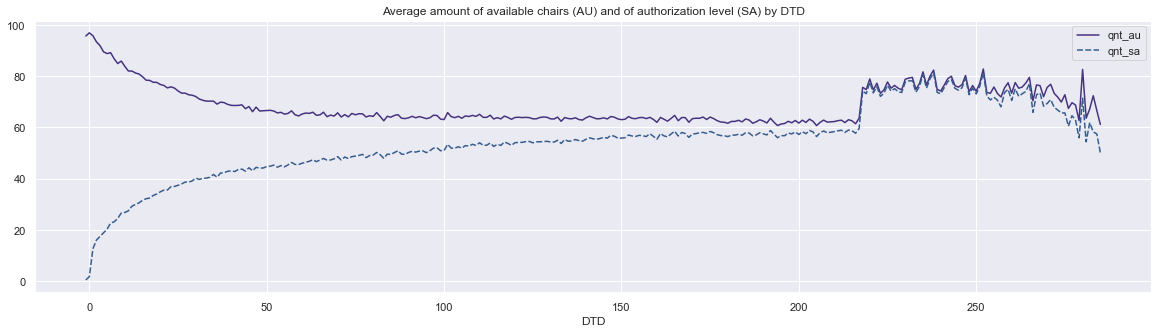

In [24]:
class_history_plot = class_history.groupby(['DTD']).agg(qnt_au=('AU', 'mean'), qnt_sa=('SA', 'mean'))

plt.figure(figsize=(20,5))
sns.lineplot(data=class_history_plot[['qnt_au', 'qnt_sa']])
plt.title("Average amount of available chairs (AU) and of authorization level (SA) by DTD")
plt.show()

Dataset insights:
- Field PASS_DEP is filled only for DTD = -1. Therefore, if we sum up PASS_DEP on DTD we receive factual amount of passangers
- На последнем графике видно, что около 60 дней до вылета начинается особенно активное бронирование мест.

# Training Dataset Ctreation and Feature Engineering

Model Feature for Training:
- Date Features: Day of Departure / Date of recording month/weekday/week/day of year/hours; hour of departure / arrival
- holiday
- SORG
- SDST
- SSCL1 - saloons. Might be important. For some reasons naming in CLASS_ and CABIN_ is different: Y/J vs Y/C
- DTD - has expressed influence on demand
- SEg_CLASS_CODE - type of tariff
- FLT_FREQ_TOTAL and FLT_FREQ_MONTH - frequency of flights. This feature is very important
- AVG max temperature in the week/month of arrival at the area of arrival/departure. And the difference between them
- Seasonal component - total, of the route, of the booking class
- CAP_J
- CAP_Y

Other feature to consider and experiment (mostly cannot simply be used; some inventions are required):
- UAL_J
- UAL_Y
- FLT_NUM - does not mean a lot by itself
- Amount of flights in the other side for the elapsed period of time. Can be very helpful
- EQUIP1 - should not be used. Instead, its capacity (features higher) could mean better improvement of the model
- SDAT_S - does not look useful as it echoes DTD
- overbooking_plan
- NS_other
- NS
- PASS_DEP
- FCLCLD - not clear how to interpret it
- Flight duration - not sure will improve score anyhow
- Field NBCL doesn't look to bring any extra value, given that we have feature SEG_CLASS_CODE

In [25]:
cabin_history.drop(columns=['LGNUM', 'SAK'], inplace=True)
class_history.drop(columns=['SAK', 'SEG_NUM'], inplace=True)

In [26]:
# flight frequency - average interval between flights
cabin_by_flt_num = cabin_history.groupby(['FLT_NUM'], as_index=False)\
                                .agg(DEP_DATE_MIN=('DEP_DATE', 'min'),
                                     DEP_DATE_MAX=('DEP_DATE', 'max'),
                                     FLT_QNT=('DEP_DATE', 'nunique'))
cabin_by_flt_num['days'] = (cabin_by_flt_num.DEP_DATE_MAX - cabin_by_flt_num.DEP_DATE_MIN).dt.days
cabin_by_flt_num['FLT_FREQ_TOTAL'] = cabin_by_flt_num['days'] / cabin_by_flt_num['FLT_QNT']

# let us get flights frequencies by months and years
cabin_by_flt_num_week  = cabin_history.groupby(['FLT_NUM', 'DEP_DATE_MONTH', 'DEP_DATE_YEAR'], as_index=False)\
                                      .agg(DEP_DATE_MIN=('DEP_DATE', 'min'),
                                           DEP_DATE_MAX=('DEP_DATE', 'max'),
                                           FLT_QNT=('DEP_DATE', 'nunique'))
cabin_by_flt_num_week['days'] = (cabin_by_flt_num_week.DEP_DATE_MAX - cabin_by_flt_num_week.DEP_DATE_MIN).dt.days
cabin_by_flt_num_week['FLT_FREQ_MONTH'] = cabin_by_flt_num_week['days'] / cabin_by_flt_num_week['FLT_QNT']

# let us get flights frequencies by months averaged over the years
cabin_by_flt_num_week_avg = cabin_by_flt_num_week.groupby(['FLT_NUM', 'DEP_DATE_MONTH'], as_index=False)\
                                                 .agg(FLT_FREQ_MONTH_AVG=('FLT_FREQ_MONTH', 'mean'))


# parsing of CAP values by saloons
cabin_history['CAP_J'] = 0
cabin_history['CAP_Y'] = 0
cabin_history.loc[~cabin_history.SSC.str.contains("J"), 'CAP_Y'] = cabin_history.CAP
cabin_history.loc[cabin_history.SSC.str.contains("J"), 'CAP_J'] = cabin_history.CAP.str.split('/').str[0]
cabin_history.loc[cabin_history.SSC.str.contains("J"), 'CAP_Y'] = cabin_history.CAP.str.split('/').str[1]

# parsing of UAL values by saloons
cabin_history['UAL_J'] = 0
cabin_history['UAL_Y'] = 0
cabin_history.loc[~cabin_history.SSC.str.contains("J"), 'UAL_Y'] = cabin_history.UAL
cabin_history.loc[cabin_history.SSC.str.contains("J"), 'UAL_J'] = cabin_history.UAL.str.split('/').str[0]
cabin_history.loc[cabin_history.SSC.str.contains("J"), 'UAL_Y'] = cabin_history.UAL.str.split('/').str[1]

cabin_history = cabin_history.astype({'UAL_Y': 'int', 'UAL_J': 'int', 'CAP_Y': 'int', 'CAP_J': 'int'})

# overbooking in percents
cabin_history['overbooking_plan_J'] = cabin_history['UAL_J'] / cabin_history['CAP_J']
cabin_history['overbooking_plan_Y'] = cabin_history['UAL_Y'] / cabin_history['CAP_Y']

# parsing of number of available seats by saloons
cabin_history['available_J'] = cabin_history.SAL.str.split('/').str[0]
cabin_history['available_Y'] = cabin_history.SAL.str.split('/').str[1]

cabin_history = reduce_memory_usage(cabin_history)

Memory usage of dataframe is 366.37 MB
Memory usage became:  228.1062126159668  MB


In [77]:
# creating extra features
class_history.loc[:, 'NS_other'] = class_history['PASS_BK'] - class_history['PASS_DEP'] - class_history['NS']
class_history.loc[class_history['NS_other'] < 0, 'NS_other'] = 0
class_history['demand'] = class_history['PASS_DEP'] + class_history['NS'] + class_history['NS_other']

In [78]:
class_history

SDAT_S  FLT_NUM         DD SORG SDST SSCL1 SEG_CLASS_CODE NBCL  \
25868992 2019-01-29     1116 2019-04-17  SVO  AER     C              D    C   
16272335 2018-08-28     1139 2019-05-03  AER  SVO     Y              H    K   
18614334 2018-12-27     6180 2019-03-13  AER  SVO     C              Z    I   
39633393 2018-12-26     1128 2019-06-24  SVO  AER     Y              B    Y   
20819246 2017-09-25     1126 2018-04-19  SVO  AER     Y              L    H   
...             ...      ...        ...  ...  ...   ...            ...  ...   
11963263 2018-12-31     1127 2019-02-26  AER  SVO     Y              M    B   
19099921 2019-01-19     1135 2019-03-26  AER  SVO     C              Z    I   
69265614 2018-06-14     1642 2018-03-10  SVO  ASF     Y              B    Y   
87795051 2019-03-25     1136 2019-12-13  SVO  AER     C              C    J   
68287093 2018-04-18     1139 2018-10-23  AER  SVO     Y              T    Q   

          FCLCLD  PASS_BK  ...  DD_day  DD_week  DD_year  SDAT_S_month  \
25868992       0        0  ...      17       16     2019             1   
16272335       0        0  ...       3       18     2019             8   
18614334       0        0  ...      13       11     2019            12   
39633393       0        0  ...      24       26     2019            12   
20819246       0        0  ...      19       16     2018             9   
...          ...      ...  ...     ...      ...      ...           ...   
11963263       0        0  ...      26        9     2019            12   
19099921       0        0  ...      26       13     2019             1   
69265614       0        0  ...      10       10     2018             6   
87795051       0        0  ...      13       50     2019             3   
68287093       0        0  ...      23       43     2018             4   

          SDAT_S_dayofyear  SDAT_S_day  SDAT_S_week  SDAT_S_year  NS_other  \
25868992                29          29            5         2019         0   
16272335               240          28           35         2018         0   
18614334               361          27           52         2018         0   
39633393               360          26           52         2018         0   
20819246               268          25           39         2017         0   
...                    ...         ...          ...          ...       ...   
11963263               365          31            1         2018         0   
19099921                19          19            3         2019         0   
69265614               165          14           24         2018         0   
87795051                84          25           13         2019         0   
68287093               108          18           16         2018         0   

          demand  
25868992       0  
16272335       0  
18614334       0  
39633393       0  
20819246       0  
...          ...  
11963263       0  
19099921       0  
69265614       0  
87795051       0  
68287093       0  

[2000000 rows x 27 columns]

In [79]:
# total seasonality
class_seasonality_by_dd = class_history.query("(DTD == -1) & (demand > 0)").groupby(["DD"], as_index=False)['demand'].sum()
class_seasonality_by_dd = class_seasonality_by_dd.sort_values(by='DD').set_index('DD')
seasonality_by_dd = seasonal_decompose(class_seasonality_by_dd, model='multiplicative', period=7).trend.reset_index()
seasonality_by_dd['month'] = seasonality_by_dd.DD.dt.month
seasonality_by_dd['day'] = seasonality_by_dd.DD.dt.day
seasonality_by_dd = seasonality_by_dd.groupby(['month', 'day'], as_index=False)['trend'].mean()

# booking class seasonality
seasonality_by_class = pd.DataFrame(columns=['class_name', 'day', 'month', 'trend'])
for class_name in class_history.SEG_CLASS_CODE.unique():
    class_days = class_history.query("(DTD == -1) & (demand > 0) & (SEG_CLASS_CODE == @class_name)").groupby(["DD"], as_index=False)['demand'].sum()
    class_days = class_days.sort_values(by='DD').set_index('DD')
     # 14 is the minimal days that are required to calculate seasonality
    if len(class_days) > 14:
        class_seasonality_by_class = seasonal_decompose(class_days, model='multiplicative', period=7).trend.reset_index()
        class_seasonality_by_class['month'] = class_seasonality_by_class.DD.dt.month
        class_seasonality_by_class['day'] = class_seasonality_by_class.DD.dt.day
        class_seasonality_by_class = class_seasonality_by_class.groupby(['month', 'day'], as_index=False)['trend'].mean()
        class_seasonality_by_class['class_name'] = class_name
        seasonality_by_class = pd.concat([seasonality_by_class, class_seasonality_by_class], ignore_index=True)
seasonality_by_class.fillna(method='ffill', inplace=True)

# booking class routes
routes = class_history[['SORG', 'SDST']].drop_duplicates().reset_index(drop=True)
seasonality_by_route = pd.DataFrame(columns=['SORG', 'SDST', 'day', 'month', 'trend'])
for _, (SORG, SDST) in routes.iterrows():
    class_days = class_history.query("(DTD == -1) & (demand > 0) & (SORG == @SORG) & (SDST == @SDST)").groupby(["DD"], as_index=False)['demand'].sum()
    class_days = class_days.sort_values(by='DD').set_index('DD')
    # 14 is the minimal days that are required to calculate seasonality
    if len(class_days) > 14:
        route_seasonality_by_route = seasonal_decompose(class_days, model='multiplicative', period=7).trend.reset_index()
        route_seasonality_by_route['month'] = route_seasonality_by_route.DD.dt.month
        route_seasonality_by_route['day'] = route_seasonality_by_route.DD.dt.day
        route_seasonality_by_route = route_seasonality_by_route.groupby(['month', 'day'], as_index=False)['trend'].mean()
        route_seasonality_by_route['SORG'] = SORG
        route_seasonality_by_route['SDST'] = SDST
        seasonality_by_route = pd.concat([seasonality_by_route, route_seasonality_by_route], ignore_index=True)
seasonality_by_route = seasonality_by_route.rename(columns={'trend': 'trend_route'})
seasonality_by_route.fillna(method='ffill', inplace=True)

In [80]:
%%time
# creating dataset for train
def get_train_dataset(class_history):
    class_data = class_history.copy()

    for categorical_column in class_history.select_dtypes('category').columns:
        # if categorical_column not in ['DD', 'SDAT_S']:
        class_history[categorical_column] = class_history[categorical_column].str.strip()

    # class_history['route'] = class_history[['SORG', 'SDST']].parallel_apply("".join, axis=1)
    class_history['DD'] = pd.to_datetime(class_history['DD'])
    class_history['SDAT_S'] = pd.to_datetime(class_history['SDAT_S'])

    class_history['DD_month'] = pd.to_datetime(class_history['DD']).dt.month
    class_history['DD_dayofyear'] = pd.to_datetime(class_history['DD']).dt.dayofyear
    class_history['DD_day'] = pd.to_datetime(class_history['DD']).dt.day
    class_history['DD_week'] = pd.to_datetime(class_history['DD']).dt.week
    class_history['DD_year'] = pd.to_datetime(class_history['DD']).dt.year

    class_history['SDAT_S_month'] = pd.to_datetime(class_history['SDAT_S']).dt.month
    class_history['SDAT_S_dayofyear'] = pd.to_datetime(class_history['SDAT_S']).dt.dayofyear
    class_history['SDAT_S_day'] = pd.to_datetime(class_history['SDAT_S']).dt.day
    class_history['SDAT_S_week'] = pd.to_datetime(class_history['SDAT_S']).dt.week
    class_history['SDAT_S_year'] = pd.to_datetime(class_history['SDAT_S']).dt.year

    train = class_data.merge(
        airports_weather_data.groupby(['iata', 'week'])['tmax'].mean(),
        left_on=['SORG', 'DD_week'],
        right_on=['iata', 'week'],
        how='left'
    ).merge(
        airports_weather_data.groupby(['iata', 'month'])['tmax'].mean(),
        left_on=['SORG', 'DD_month'],
        right_on=['iata', 'month'],
        how='left',
        suffixes=('_WEEK_SORG', '_MONTH_SORG')
    ).merge(
        airports_weather_data.groupby(['iata', 'week'])['tmax'].mean(),
        left_on=['SDST', 'DD_week'],
        right_on=['iata', 'week'],
        how='left'
    ).merge(
        airports_weather_data.groupby(['iata', 'month'])['tmax'].mean(),
        left_on=['SDST', 'DD_month'],
        right_on=['iata', 'month'],
        how='left',
        suffixes=('_WEEK_SDST', '_MONTH_SDST')
    ).merge(
        cabin_by_flt_num[['FLT_NUM', 'FLT_FREQ_TOTAL']],
        left_on=['FLT_NUM'],
        right_on=['FLT_NUM'],
        how='left'    
    ).merge(
        cabin_by_flt_num_week_avg[['FLT_NUM', 'DEP_DATE_MONTH', 'FLT_FREQ_MONTH_AVG']],
        left_on=['FLT_NUM', 'DD_month'],
        right_on=['FLT_NUM', 'DEP_DATE_MONTH'],
        how='left'    
    ).merge(
        russian_holidays,
        left_on=['DD'],
        right_on=['date'],
        how='left'    
    ).merge(
        russian_holidays,
        left_on=['SDAT_S'],
        right_on=['date'],
        how='left',
        suffixes=('_DD', '_SDAT_S')
    ).merge(
        seasonality_by_dd,
        left_on=['DD_month', 'DD_day'],
        right_on=['month', 'day'],
        how='left'
    ).merge(
        seasonality_by_class,
        left_on=['SEG_CLASS_CODE', 'DD_month', 'DD_day'],
        right_on=['class_name', 'month', 'day'],
        how='left',
        suffixes=('_total', '_class')
    ).merge(
        seasonality_by_route,
        left_on=['SORG', 'SDST', 'DD_month', 'DD_day'],
        right_on=['SORG', 'SDST', 'month', 'day'],
        how='left'
    ).merge(
        cabin_history.groupby(['FLT_NUM', 'DEP_DATE'], as_index=False)\
            .agg({'TT_DEP_HRS': 'mean', 'TT_ARR_HRS': 'mean',
                  'CAP_J': 'max', 'CAP_Y': 'max'}),
        left_on=['FLT_NUM', 'DD'],
        right_on=['FLT_NUM', 'DEP_DATE'],
        how='left'
    )
    
    train.fillna(value={'holiday_DD': 0, 'holiday_SDAT_S': 0}, inplace=True)
    train[['trend_total', 'trend_class', 'trend_route']].fillna(method='ffill', inplace=True)
    train.rename(columns={'FLT_FREQ_MONTH_AVG': 'FREQ'}, inplace=True)

    train.drop(columns=['FLT_NUM', 'SDAT_S', 'DD', 'NBCL', 'FCLCLD', 'PASS_BK', 'SA', 'AU', 'PASS_DEP', 'NS', 'NS_other',
                        'date_DD', 'date_SDAT_S', 'class_name', 'day_class', 'month_total', 'day_total', 'month_class',
                        'day', 'month', 'DEP_DATE', 'DEP_DATE_MONTH', 'FLT_FREQ_TOTAL'], inplace=True)

    return reduce_memory_usage(train)

train = get_train_dataset(class_history)
# del class_history
train.to_pickle("aeroflot_train.pkl")
train = train.astype({'tmax_WEEK_SORG': 'int', 'tmax_MONTH_SORG': 'int',
                      'tmax_WEEK_SDST': 'int', 'tmax_MONTH_SDST': 'int'})

Memory usage of dataframe is 410.08 MB
Memory usage became:  104.90595245361328  MB
Wall time: 15.9 s


# ML Algorithm

In [81]:
X = train.drop(columns=['demand'])
Y = train['demand']
# del train
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42, shuffle=True)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.33, random_state=42, shuffle=True)

## Hyperparameters optimization using Bayesian Optimization

In [83]:
catboost_hyperparams = { 'learning_rate': hp.choice('learning_rate', np.arange(0.05, 0.5, 0.05)),
                         'max_depth': hp.choice('max_depth', np.arange(2, 16, 1, dtype=int)),
                         'colsample_bylevel': hp.choice('colsample_bylevel', np.arange(0.3, 0.8, 0.1)),
                         'l2_leaf_reg': hp.randint('l2_leaf_reg', 1, 10),
                         'n_estimators': 100}

In [84]:
# define the objective function which for this model is the RMSE
def objective(search_space):
    model = CatBoostRegressor(**search_space,
                              loss_function='RMSE',
                              eval_metric='RMSE',
                              early_stopping_rounds=100,
                              random_seed=42)

    model.fit(X = X_train,
              y = y_train,
              eval_set=(X_valid,y_valid),
              verbose=False,
              cat_features=np.where(X_train.dtypes == 'category')[0])
    return {'loss': model.get_best_score()['validation']['RMSE'], 'status': STATUS_OK}

In [85]:
# algorithm=tpe.suggest
#
# # search for best parameters
# best_params = fmin(
#     fn=objective,
#     space=catboost_hyperparams,
#     algo=algorithm,
#     max_evals=100)
# # dict of the best params
# hyperparams = space_eval(catboost_hyperparams, best_params)

In [86]:
hyperparams = {'colsample_bylevel': 0.4,
               'l2_leaf_reg': 7,
               'learning_rate': 0.25,
               'max_depth': 8,
               'n_estimators': 100}

In [87]:
params = {'learning_rate' : hyperparams['learning_rate'],
          # 'iterations' : hyperparams['iterations'],
          'max_depth' : hyperparams['max_depth'],
          'loss_function' : 'RMSE',
          'l2_leaf_reg' : hyperparams['l2_leaf_reg'],
          'eval_metric' : 'RMSE',
          'early_stopping_rounds': 100,
          'colsample_bylevel' : hyperparams['colsample_bylevel'],
          'iterations': 50}

In [88]:
model = CatBoostRegressor(**params, random_seed=42)
y_train = y_train.fillna(0)
y_valid = y_valid.fillna(0)
model.fit(X = X_train,
          y = y_train,
          eval_set=(X_valid,y_valid),
          verbose=False,
          cat_features=np.where(X_train.dtypes == 'category')[0])
model.save_model(f"../AeroflotForecast/models/AeroflotPredicter_final")

In [ ]:
# for file in glob.glob("../AeroflotForecast/data/interim/*.pkl"):
#     file_data = pd.read_pickle(file)
#     border = len(file_data) // 2
#     file_data[:border].to_csv(file[:-4] + '_part_1.csv', sep=';')
#     file_data[border:].to_csv(file[:-4] + '_part_2.csv', sep=';')

In [ ]:
# for indx, file in enumerate(glob.glob("../AeroflotForecast/data/interim/new/*.pkl")):
#     file_data = pd.read_pickle(file)
#     # file_data = pd.read_csv(file, sep=";")
#     X = file_data.drop(columns=['demand']).fillna(0)
#     Y = file_data['demand'].fillna(0)
#     X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.3, random_state=42, shuffle=True)
#
#     if np.mean(Y) == 0:
#         continue
#
#     model.fit(X = X_train,
#               y = y_train,
#               eval_set=(X_valid,y_valid),
#               verbose=False,
#               cat_features=np.where(X_train.dtypes == 'category')[0])
#
#     model.save_model(f"../AeroflotForecast/models/AeroflotPredicter_{indx}")
#     print(file)

In [ ]:
model.save_model("AeroflotPredicter")

In [ ]:
print('best RMSE', model.get_best_score()['validation']['RMSE'])

In [ ]:
# Idea of model training by chunks: https://www.kaggle.com/code/cdeotte/xgboost-baseline-0-680
# model = catboost_model_regre|ssor(X_train, X_test, y_train, y_test)
y_pred = model.predict(X_test)

In [ ]:
np.sqrt(mean_squared_error(y_pred, y_test))

In [ ]:
np.mean(mean_absolute_percentage_error(y_pred, y_test))

In [ ]:
train_preds = model.predict(X_train)

residual_plot(y_train[:10000], train_preds[:10000],
              y_test[:10000], y_pred[:10000],
              title="CatBoost Residual Plot")

## Features Importance

In [ ]:
feat_importances = model.get_feature_importance(prettified=True)

plt.figure(figsize=(12, 10))
sns.barplot(x="Importances", y="Feature Id", data=feat_importances.loc[:30, :])
plt.title('CatBoost features importance:')

In [ ]:
train_data = Pool(data=X_train, label=y_train, cat_features=np.where(X_train.dtypes == 'category')[0])
val_data = Pool(data=X_valid, label=y_valid, cat_features=np.where(X_valid.dtypes == 'category')[0])

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_data)

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[:100,:], X_train.iloc[:100,:])

In [ ]:
shap.summary_plot(shap_values, X_train)

Research Results of Feature Importance:
As it can be seen from feature importance analysis, the most important feature is, surprisingly, class seasonality. Second place takes class code, which is tightly connected to final price of the flight and thus raise no question as to why it takes second position (simply put - the more expensive tickets are the fewer people are buying them). Other important factors to consider are route seasonality, flight frequency, date features (that also represent some seasonality), and, finally, temperature of destination and origination points.

Further steps to work on:
1) Take social events into account (such as Formula-1, or big concerts);
2) Upload cities embedding into model that would characterize cities' business, cultural, and resort capacities;
3) Cities statistics on bar amount, crime rate

## Predictions to daily format

In [ ]:
send = X_train
send['PRED_DEMAND'] = train_preds
send['PRED_DATE'] = str(datetime.today().date())
send = send.astype({'SDAT_S_year': str, 'SDAT_S_month': str, 'SDAT_S_day': str})
send['SDAT_S_month'] = send['SDAT_S_month'].apply(lambda x: "0" + x if int(x) < 10 else x)
send['SDAT_S_day'] = send['SDAT_S_day'].apply(lambda x: "0" + x if int(x) < 10 else x)
send['SDAT_S'] = send[['SDAT_S_year', 'SDAT_S_month', 'SDAT_S_day']].parallel_apply("-".join, axis=1)
pysqldf("""select PRED_DATE, SDAT_S, SEG_CLASS_CODE, FLT_NUM, max(PRED_DEMAND, 0) PRED_DEMAND FROM send""").to_excel("predictions.xlsx")

## 2020 Prediction

## Dataset transformation

In [44]:
# first we receive chunks to process
def ranges(n, nb):
    """The total number of elements in the range N and a number of chunks nb"""

    step = n / nb
    return [(round(step * i), round(step * (i + 1))) for i in range(nb)]

slice_ranges = ranges(len(rasp_history), 400)

In [47]:
rasp_history = pd.read_pickle("../AeroflotForecast/data/processed/rasp_history")
# deleting spaces from DataFrame
for categorical_column in rasp_history.select_dtypes('category').columns:
    rasp_history[categorical_column] = rasp_history[categorical_column].str.strip()

rasp_history

AIRLINE_CODESH  FLT_NUMSH LEG_ORIG LEG_DEST   EFFV_DATE   DISC_DATE  \
0                 SU       1642      SVO      ASF  12.01.2020  14.03.2020   
1                 SU       1642      SVO      ASF  15.03.2020  20.03.2020   
2                 SU       1642      SVO      ASF  15.03.2020  20.03.2020   
3                 SU       1642      SVO      ASF  21.03.2020  28.03.2020   
4                 SU       1642      SVO      ASF  29.03.2020  24.10.2020   
...              ...        ...      ...      ...         ...         ...   
73007             SU       1175      ASF      SVO  31.08.2020  31.08.2020   
73008             SU       1175      ASF      SVO  01.09.2020  01.09.2020   
73009             SU       1175      ASF      SVO  02.09.2020  24.10.2020   
73010             SU       1175      ASF      SVO  25.10.2020  27.03.2021   
73011             SU       1175      ASF      SVO  28.03.2021  30.10.2021   

          FREQ  NUM_LEGS CAPTURE_DATE1  DEP_TIME1  ARR_TIME1 EQUIP1  
0      1234567         1    10.02.2020        945       1310    32A  
1       1    6         1    10.02.2020        945       1310    SU9  
2         2345         1    10.02.2020        945       1310    32A  
3      1234567         1    10.02.2020        945       1310    32A  
4      1234567         1    10.02.2020        730       1045    SU9  
...        ...       ...           ...        ...        ...    ...  
73007  1234567         1    28.08.2020       1910       2040    32A  
73008  1234567         1    28.08.2020       1910       2040    SU9  
73009  1234567         1    28.08.2020       1910       2040    32A  
73010  1234567         1    28.08.2020       1950       2110    32A  
73011  1234567         1    28.08.2020       1910       2030    32A  

[73012 rows x 12 columns]

In [ ]:
# To avoid memory error, we will read test data in small pieces of sizes:

for index, (left_index, right_index) in enumerate(slice_ranges):
    test = rasp_history.iloc[left_index:right_index].copy()
    test.rename(columns={"LEG_DEST": "SDST", "LEG_ORIG": "SORG"}, inplace=True)
    test['DEP_DATE'] = test.apply(lambda x: get_dates_from_range_and_weekdays(x.EFFV_DATE, x.DISC_DATE, x.FREQ), axis=1)
    test = test.explode('DEP_DATE')
    test['FREQ'] = test['FREQ'].apply(lambda weekdays: 7 / len([int(el) for el in weekdays if el != ' ']))

    test["TT_DEP_HRS"] = test["DEP_TIME1"] / 100  # Local Hour of Departure
    test["TT_ARR_HRS"] = test["ARR_TIME1"] / 100  # Local Hour of Arrival

    test['DEP_DATE'] = pd.to_datetime(test['DEP_DATE'])
    test['CAPTURE_DATE1'] = pd.to_datetime(test['CAPTURE_DATE1'])

    test['DD_month'] = pd.to_datetime(test['DEP_DATE']).dt.month
    test['DD_dayofyear'] = pd.to_datetime(test['DEP_DATE']).dt.dayofyear
    test['DD_day'] = pd.to_datetime(test['DEP_DATE']).dt.day
    test['DD_week'] = pd.to_datetime(test['DEP_DATE']).dt.week
    test['DD_year'] = pd.to_datetime(test['DEP_DATE']).dt.year

    test['SDAT_S_month'] = pd.to_datetime(test['CAPTURE_DATE1']).dt.month
    test['SDAT_S_dayofyear'] = pd.to_datetime(test['CAPTURE_DATE1']).dt.dayofyear
    test['SDAT_S_day'] = pd.to_datetime(test['CAPTURE_DATE1']).dt.day
    test['SDAT_S_week'] = pd.to_datetime(test['CAPTURE_DATE1']).dt.week
    test['SDAT_S_year'] = pd.to_datetime(test['CAPTURE_DATE1']).dt.year
    test['DTD'] = (test['DEP_DATE'] - test['CAPTURE_DATE1']).dt.days
    test = test.query("DTD > -1")
    CLASSESS_ALL = train[['SEG_CLASS_CODE', 'SSCL1']].drop_duplicates()
    AIRCRAFTS_CAPACITY = cabin_history.groupby(['EQUIP'], as_index=False)[['CAP_J', 'CAP_Y']].max()

    query = """
    select  *
    from    test
    cross join  CLASSESS_ALL
    left join   AIRCRAFTS_CAPACITY a on a.EQUIP = test.EQUIP1
    """

    test = pysqldf(query)

    test['DEP_DATE'] = pd.to_datetime(test['DEP_DATE'])
    test['CAPTURE_DATE1'] = pd.to_datetime(test['CAPTURE_DATE1'])

    test = test.merge(
        russian_holidays,
        left_on=['DEP_DATE'],
        right_on=['date'],
        how='left'
    ).merge(
        russian_holidays,
        left_on=['CAPTURE_DATE1'],
        right_on=['date'],
        how='left',
        suffixes=('_DD', '_SDAT_S')
    ).merge(
        seasonality_by_dd,
        left_on=['DD_month', 'DD_day'],
        right_on=['month', 'day'],
        how='left'
    ).merge(
        seasonality_by_class,
        left_on=['SEG_CLASS_CODE', 'DD_month', 'DD_day'],
        right_on=['class_name', 'month', 'day'],
        how='left',
        suffixes=('_total', '_class')
    ).merge(
        airports_weather_data.groupby(['iata', 'week'])['tmax'].mean(),
        left_on=['SORG', 'DD_week'],
        right_on=['iata', 'week'],
        how='left'
    ).merge(
        airports_weather_data.groupby(['iata', 'month'])['tmax'].mean(),
        left_on=['SORG', 'DD_month'],
        right_on=['iata', 'month'],
        how='left',
        suffixes=('_WEEK_SORG', '_MONTH_SORG')
    ).merge(
        airports_weather_data.groupby(['iata', 'week'])['tmax'].mean(),
        left_on=['SDST', 'DD_week'],
        right_on=['iata', 'week'],
        how='left'
    ).merge(
        airports_weather_data.groupby(['iata', 'month'])['tmax'].mean(),
        left_on=['SDST', 'DD_month'],
        right_on=['iata', 'month'],
        how='left',
        suffixes=('_WEEK_SDST', '_MONTH_SDST')
    ).merge(
        seasonality_by_route,
        left_on=['SORG', 'SDST', 'DD_month', 'DD_day'],
        right_on=['SORG', 'SDST', 'month', 'day'],
        how='left'
    )

    test.fillna(value={'holiday_DD': 0, 'holiday_SDAT_S': 0}, inplace=True)
    test[['trend_total', 'trend_class', 'trend_route']].fillna(method='ffill', inplace=True)
    test.fillna(0, inplace=True)

    test.drop(columns=['AIRLINE_CODESH', 'NUM_LEGS', 'EFFV_DATE', 'DISC_DATE', 'DEP_DATE',
                      'EQUIP1', 'EQUIP', 'ARR_TIME1', 'DEP_TIME1', 'class_name', 'date_DD',
                      'date_SDAT_S', 'day_class', 'day_total', 'month_class', 'month_total', 'day', 'month'], inplace=True)

    test = test.astype({'tmax_WEEK_SORG': 'int', 'tmax_MONTH_SORG': 'int',
                        'tmax_WEEK_SDST': 'int', 'tmax_MONTH_SDST': 'int',
                        'FREQ': 'int'})
    test = reduce_memory_usage(test)

    # copy dtypes from the train DataFrame
    for column in X_train.columns:
        test[column] = test[column].astype(X_train[column].dtypes.name)


    model = CatBoostRegressor()
    model.load_model("../AeroflotForecast/models/AeroflotPredicter_final")
    test['demand'] = model.predict(test[X_train.columns.to_list()])

    if index == 0:
        total = test.groupby(['FLT_NUMSH', 'SEG_CLASS_CODE', 'SORG', 'SDST', 'CAPTURE_DATE1'], as_index=False)[['demand']].sum()
    else:
        temp = test.groupby(['FLT_NUMSH', 'SEG_CLASS_CODE', 'SORG', 'SDST', 'CAPTURE_DATE1'], as_index=False)[['demand']].sum()
        total = pd.concat([total, temp], ignore_index=True)
    # model prediction
    # for indx, i_model in enumerate(glob.glob("../AeroflotForecast/models/*")):
    #     model = CatBoostRegressor()
    #     model.load_model(i_model)
    #     if indx == 0:
    #         test['demand'] = model.predict(test)
    #         test['demand'].clip(lower=0, inplace=True)
    #     else:
    #         try:
    #             test['new_demand'] = model.predict(test)
    #         except:
    #             # test.dtypes['holiday_DD']
    #             test['holiday_DD'] = test['holiday_DD'].apply(lambda x: 0 if 0 else 1)
    #             test = test.astype({'holiday_DD': 'int'})
    #             test['new_demand'] = model.predict(test)
    #
    #         test['new_demand'].clip(lower=0, inplace=True)
    #         test['demand'] = test[['demand', 'new_demand']].mean(axis=1)


    test['demand'].clip(lower=0, inplace=True)
    # test.to_csv(f"prediction_2020_chunk_number_{index}.csv", sep=';')
    print(index, 'done')

Memory usage of dataframe is 40.46 MB
Memory usage became:  10.458913803100586  MB
0 done
Memory usage of dataframe is 45.95 MB
Memory usage became:  11.879526138305664  MB
1 done
Memory usage of dataframe is 26.71 MB
Memory usage became:  6.904808044433594  MB
2 done
Memory usage of dataframe is 42.77 MB
Memory usage became:  11.056594848632812  MB
3 done
Memory usage of dataframe is 45.79 MB
Memory usage became:  11.83601188659668  MB
4 done
Memory usage of dataframe is 21.24 MB
Memory usage became:  5.4918670654296875  MB
5 done
Memory usage of dataframe is 47.92 MB
Memory usage became:  12.387603759765625  MB
6 done
Memory usage of dataframe is 36.67 MB
Memory usage became:  9.323184967041016  MB
7 done
Memory usage of dataframe is 41.23 MB
Memory usage became:  10.48385238647461  MB
8 done
Memory usage of dataframe is 39.47 MB
Memory usage became:  10.03695297241211  MB
9 done
Memory usage of dataframe is 38.96 MB
Memory usage became:  10.071125030517578  MB
10 done
Memory usage o

In [91]:
# seasonality_by_route.fillna(method='ffill').fillna(seasonality_by_route.mean()).to_csv("seasonality.csv", sep=";")

In [92]:
total_group = total.query("demand > 0")
total_group = total_group.groupby(['FLT_NUMSH', 'SEG_CLASS_CODE', 'SORG', 'SDST', 'CAPTURE_DATE1'], as_index=False)[['demand']].sum().query("demand > 0")
# total_group.to_excel("final_prediction_2020.xlsx")
total_group

FLT_NUMSH SEG_CLASS_CODE SORG SDST CAPTURE_DATE1      demand
24          1116              B  SVO  AER    2020-02-21  108.389678
25          1116              B  SVO  AER    2020-02-22  109.242890
27          1116              B  SVO  AER    2020-10-02   26.791870
60          1116              C  SVO  AER    2020-02-21   29.255150
61          1116              C  SVO  AER    2020-02-22   29.774447
...          ...            ...  ...  ...           ...         ...
26843       1643              X  ASF  SVO    2020-10-02  107.028364
26876       1643              Y  ASF  SVO    2020-02-21   23.476605
26878       1643              Y  ASF  SVO    2020-02-24   23.711425
26879       1643              Y  ASF  SVO    2020-10-02   12.885750
26915       1643              Z  ASF  SVO    2020-10-02    5.229137

[1976 rows x 6 columns]

In [93]:
total_group[total_group['FLT_NUMSH'] == 1116]['demand'].sum()

14609.294446152851